In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import re
import os
import tqdm
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)
import pylab
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,make_scorer,accuracy_score,precision_score,recall_score,f1_score,mean_squared_log_error
from xgboost import XGBRFRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv(os.path.join(os.getcwd(),'data/BikeSharingDemand/train.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/BikeSharingDemand/test.csv'))
combine=[train,test]

In [3]:
def check_null(df):
    flag=df.isnull().sum().any()
    if flag == True:
        total=df.isnull().sum().sort_values(ascending=False)
        percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
        missing=pd.concat([total,percent],axis=1,keys=['total','percent'])
        
        data_type=[]
        for col in columns:
            dtype=df[col].dtype
            data_type.append(dtype)
        missing['dtype']=data_type
        return missing
    else:
        return False

In [9]:
for df in combine:
    df['date']=df.datetime.apply(lambda x:pd.to_datetime(x).strftime('%Y-%m-%d'))
    df['hour']=df.datetime.apply(lambda x:pd.Timestamp(x).hour)
    df['month']=df.datetime.apply(lambda x:pd.Timestamp(x).month)
    df['year']=df.date.apply(lambda x:pd.Timestamp(x).year)
    df['weekday']=df.datetime.apply(lambda x:pd.Timestamp(x).weekday())

for df in combine:
    df.drop(['datetime'],axis=1,inplace=True)
combine=[train,test]
train.rename(columns={'count':'ncount'},inplace=True)

## DEA

Text(0.5, 1.0, 'Workingday boxplot')

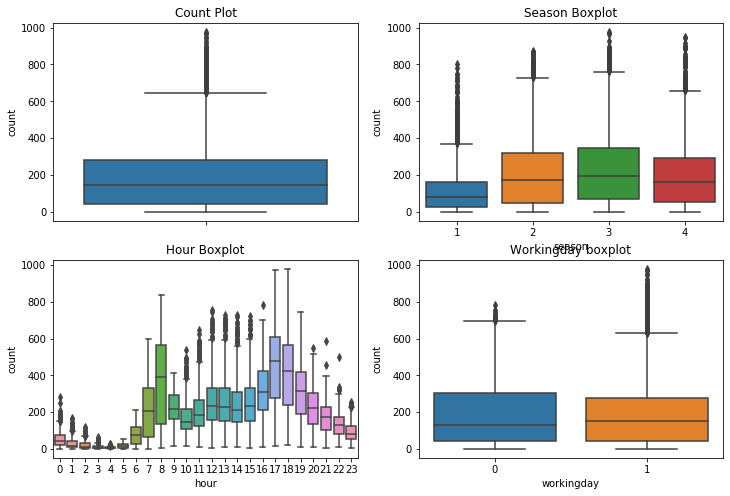

In [37]:
f,axes=plt.subplots(2,2,figsize=(12,8))
sns.boxplot(train['count'],orient='v',ax=axes[0][0]).set_title('Count Plot')
sns.boxplot(train['season'],train['count'],orient='v',ax=axes[0][1]).set_title('Season Boxplot')
sns.boxplot(train['hour'],train['count'],ax=axes[1][0]).set_title('Hour Boxplot')
sns.boxplot(train['workingday'],train['count'],ax=axes[1][1]).set_title('Workingday boxplot')

In [15]:
## Outliers
q1=train.ncount.quantile(0.25)
q3=train.ncount.quantile(0.75)
iqr=q3-q1
cut_off=iqr*1.5
lower,upper=q1-cut_off,q3+cut_off
outliers=[x for x in train.ncount if x <lower or x>upper]
train_no_countoutliers=train[~train.ncount.isin(outliers)]

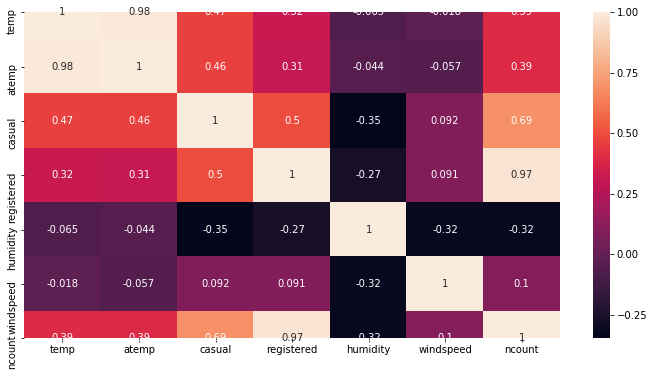

In [97]:
## 'atemp' needs to be dropped as collinearity issues.
## 'casual'&'registered' are leakage variables needs to be dropped
plt.figure(figsize=(12,6))
sns.heatmap(train[['temp','atemp','casual','registered','humidity','windspeed','ncount']].corr(),annot=True)

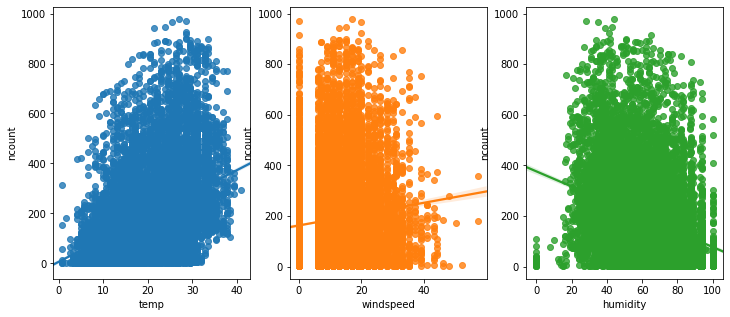

In [104]:
## LinearRegression fit plots 
f,axes=plt.subplots(1,3,figsize=(12,5))
sns.regplot(train.temp,train.ncount,ax=axes[0])
sns.regplot(train.windspeed,train.ncount,ax=axes[1])
sns.regplot(train.humidity,train.ncount,ax=axes[2])

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.364739645924417, 4.591363690454027, 0.9611793780126949))

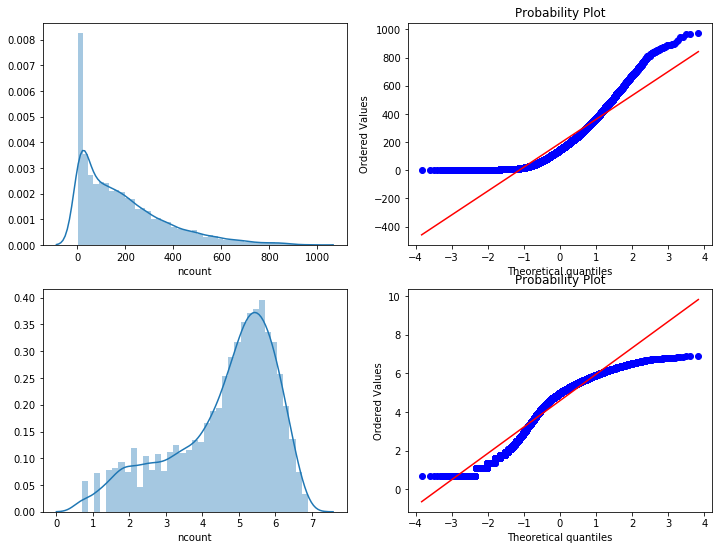

In [109]:
f,axes=plt.subplots(2,2,figsize=(12,9))
sns.distplot(train.ncount,ax=axes[0][0])
stats.probplot(train.ncount,plot=axes[0][1])
sns.distplot(np.log1p(train.ncount),ax=axes[1][0])
stats.probplot(np.log1p(train.ncount),plot=axes[1][1])

In [ ]:
month_mean=train.groupby(['month']).agg({'ncount':np.median})
month_mean=pd.DataFrame({'month':month_mean.index,'mean_count':month_mean.ncount.values})
hour_season=pd.DataFrame(train.groupby(['hour','season']).median()['ncount'].reset_index())
hour_weekday=pd.DataFrame(train.groupby(['hour','weekday']).median()['ncount'].reset_index())
## pd.melt to group variables into one row
hour_casual=pd.melt(train[['hour','casual','registered']],id_vars=['hour'],value_vars=['casual','registered'])
hour_casual=hour_casual.groupby(['hour','variable']).median().reset_index()

Text(0.5, 1.0, 'Mean Count Per Hour & Type')

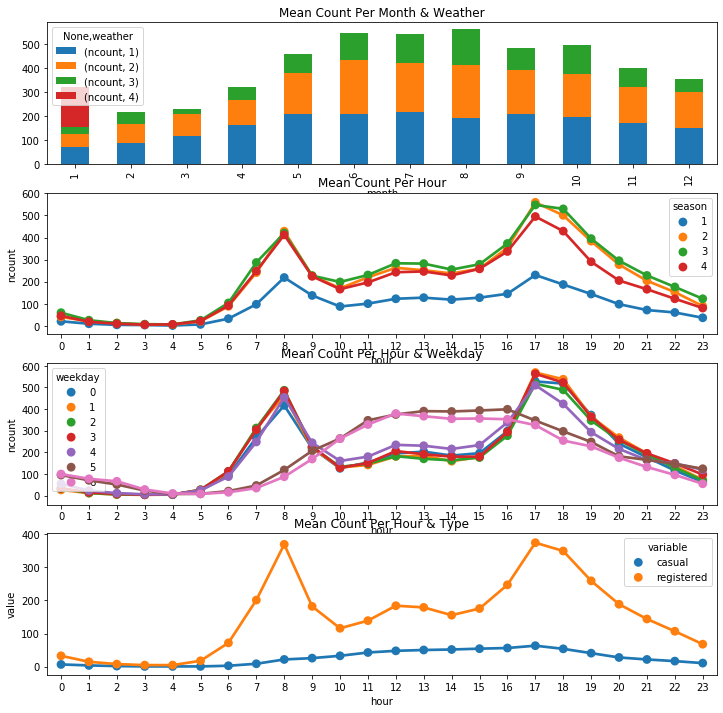

In [178]:
f,axes=plt.subplots(4,figsize=(12,12))
train.groupby(['month','weather']).agg({'ncount':np.median}).unstack(['weather']).plot(kind='bar',stacked=True,ax=axes[0],title='Mean Count Per Month & Weather')
sns.pointplot(hour_season.hour,hour_season.ncount,hue=hour_season.season,ax=axes[1]).set_title('Mean Count Per Hour')
sns.pointplot(hour_weekday.hour,hour_weekday.ncount,hue=hour_weekday.weekday,ax=axes[2]).set_title('Mean Count Per Hour & Weekday')
sns.pointplot(hour_casual.hour,hour_casual.value,hue=hour_casual.variable,ax=axes[3]).set_title('Mean Count Per Hour & Type')

## Feature Engineering

In [17]:
for df in combine:
    df['humidity_band']=pd.qcut(df.humidity,3)
    df.loc[(df.humidity>-0.001) & (df.humidity<=52),'humidity_new']=0
    df.loc[(df.humidity>52)&(df.humidity<=72),'humidity_new']=1
    df.loc[(df.humidity>72)&(df.humidity<=100),'humidity_new']=2
    df.drop(['humidity_band'],axis=1,inplace=True)
combine=[train,test]

In [12]:
## Fill up windspeed ==0 by the combination of humidity_new & month
for df in combine:
    guess_windspeed=np.zeros((12,3))
    for i in range(0,12):
        for j in range(0,3):
            guess_df=df[(df.month==i+1) & (df.humidity_new==j)&(df.windspeed!=0)]['windspeed']
            median=guess_df.median()
            guess_windspeed[i,j]=median
    for i in range(0,12):
        for j in range(0,3):
            df.loc[(df.month==i+1) & (df.humidity_new==j)&(df.windspeed==0),'windspeed']=guess_windspeed[i,j]

In [18]:
for df in combine:
    df.drop(['humidity_new'],axis=1,inplace=True)

combine=[train,test]
for df in combine:
    df['date']=df.date.apply(lambda x: pd.to_datetime(x))
num_features=train.select_dtypes(exclude=['object']).columns
dropfeatures=['casual','ncount',"date","registered"]

train_new=train.drop(dropfeatures,axis=1)
test_new=test.copy().drop(['date'],axis=1)
y=train.ncount.values

## Ridge CV & Lasso CV

In [136]:
def rmsle(y,y_,convertExp=True):
    if convertExp:
        y = np.exp(y)
        y_=np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y_]))
    calc =(log1-log2) ** 2
    return np.sqrt(np.mean(calc))

In [167]:
ridge=Ridge()
ridge_params={'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000] }
scorer=make_scorer(rmsle,greater_is_better=False)
clf=GridSearchCV(ridge,ridge_params,scoring=scorer,cv=5)
y_log1p=np.log1p(y)
clf.fit(train_new,y_log1p)
y_pred=clf.predict(train_new)
rmsle(np.exp(y_log1p),np.exp(y_pred),False)

In [193]:
cv_df=pd.DataFrame(clf.cv_results_)
cv_df['mean_test_score_positive']=cv_df.mean_test_score.apply(lambda x:-x)

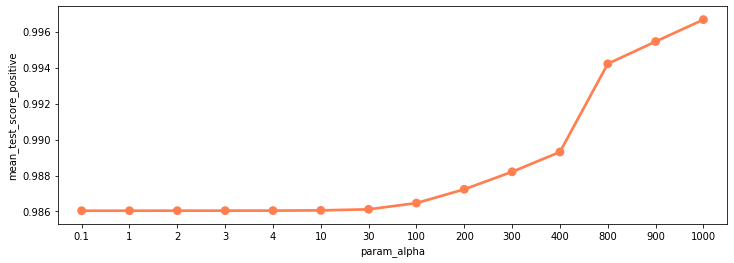

In [205]:
f,ax=plt.subplots(figsize=(12,4))
sns.pointplot(cv_df.param_alpha,cv_df.mean_test_score_positive,color='coral')

In [214]:
lass=Lasso()
alpha=1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
params={'max_iter':[3000],'alpha':alpha}
clf=GridSearchCV(lass,params,scoring=scorer,cv=5)
clf.fit(train_new,y_log1p)
df_lasso=pd.DataFrame(clf.cv_results_)
df_lasso['mean_test_score_positive']=df_lasso.mean_test_score.apply(lambda x: -x)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

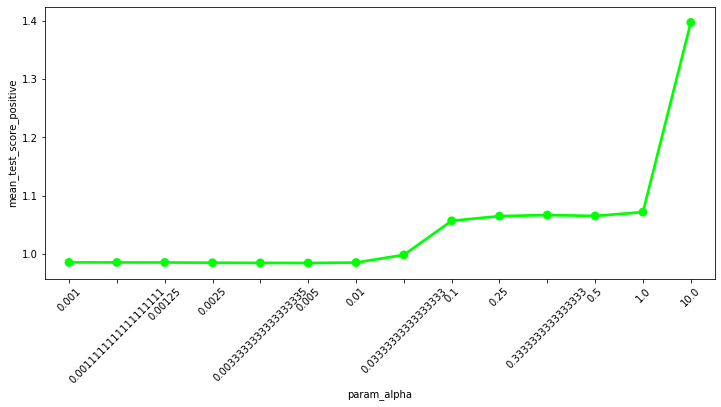

In [226]:
plt.figure(figsize=(12,5))
sns.pointplot(df_lasso.param_alpha,df_lasso.mean_test_score_positive,color='lime')
plt.xticks(rotation=45)

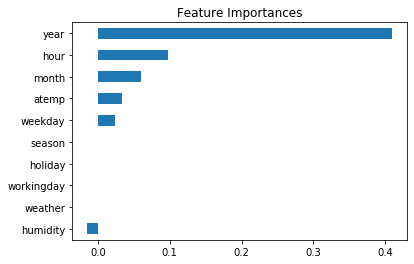

In [245]:
coef=pd.Series(clf.best_estimator_.coef_,index=train_new.columns).sort_values(ascending=False)
pd.concat([coef.sort_values().head(5),coef.sort_values().tail(5)]).plot(kind='barh',title='Feature Importances')

In [260]:
pipeline=make_pipeline(StandardScaler(),XGBRFRegressor())
params={'xgbrfregressor__gamma':[0,0.1,0.9],
'xgbrfregressor__learning_rate':[0,0.5,0.8],
 'xgbrfregressor__max_depth':[3,5],
 'xgbrfregressor__n_estimators':[500,1000] }
scorer=make_scorer(rmsle,greater_is_better=False)
clf=GridSearchCV(pipeline,params,scoring=scorer)

In [261]:
clf.fit(train_new,y_log1p)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[17:36:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgbrfregressor',
                                        XGBRFRegressor(base_score=0.5,
                                                       colsample_bylevel=1,
                                                       colsample_bynode=0.8,
                                                       colsample_bytree=1,
                                                       gamma=0, learning_rate=1,
                                                       max_delta_step=0,
                                                       max_depth=3,
                                                    

In [266]:
y_pred=clf.predict(test_new)

In [273]:
def run_kfold(clf):
    kf=KFold(n_splits=10,random_state=0)
    fold=0
    outcome=[]
    for train_index,test_index in kf.split(train_new):
        fold+=1
        X_train,X_test = train_new.values[train_index],train_new.values[test_index]
        y_train,y_test=y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        r2=r2_score(y_test,y_pred)
        outcome.append(r2)
        print('Fold {} accuracy is {}:'.format(fold,r2))
    mean=np.mean(outcome)
    print('Mean accuracy is {}'.format(mean))

In [22]:
X_train,X_test,y_train,y_test=train_test_split(train_new,y,test_size=0.25,random_state=42)

In [33]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
rmsle=[]
d={}
for model in range(len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_test)))
    d={'Modelling Algo':model_names,'RMSLE':rmsle}

In [46]:
params={'max_depth':[3,5],
       'n_estimators':[500,1000],
       'max_features':["auto",'sqrt','log2']}
clf=GridSearchCV(RandomForestRegressor(),params,scoring='neg_mean_squared_log_error')
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5],
     

In [51]:
y_pred=clf.predict(X_test)
np.sqrt(mean_squared_log_error(y_pred,y_test))

0.5990038492975372

In [61]:
y_pred=clf.predict(test_new)

In [68]:
predictions=pd.DataFrame({'Date':test.date,'Pred':y_pred})